# Likelihood of the lead submittion

### Problem Statement

You are provided with a sample of website traffic.
You are requested to create a model to predict how likely a given user is going to submit a lead in the next day.

### Goals of the Case Study

Build a model to predict the likelihood(probability) of a given user submitting the lead. The higher the number, the more likely the user will submit the lead in the next day.

In [141]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

## Dataset

The ML solution is not viable without data. In other words, there can be a ML model that was developed and trained on some data, but it will not be YOUR solution until it is trained on YOUR data.

However, we can hypothesize about what the data for the lead quality prediction would look like. The problem as such was solved many times in the past. It is kind of a classical example of applying ML to the business. Thus, it is not hard to find a public dataset of website traffic and adjust it to your needs.

Here, I took the dataset from the [Kaggle](https://www.kaggle.com/datasets/ashydv/leads-dataset) and extracted only those features that are the most general for any website traffic. Particularly, they are the features that describe the visit source (Lead Origin, Lead Source), user activity (Total Visits, Time on the website, Number of page views, Last activity), and georgraphy (Country, City). Additionally, I added three features that were manually generated by human: Tags, Lead quality, Lead profile. Generally speaking, it is rarely an opportunity for the business to have manually generated hips of data. And it is well shown in this dataset by the amount of the missing values in these thre features. Thus, these features were added for demonstration purposes.

Lastly, the target variable is represented by feature Converted.


The generated dataset was saved to 'leadsdata.csv'.

In [330]:
# importing the dataset
data=pd.read_csv("leadsdata.csv")
data.sample(5)

,UserID,Lead Origin,Lead Source,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,City,Tags,Lead Quality,Lead Profile,Converted
5112,898fe0e9-7438-49d2-977b-a1cd60d803cf,Landing Page Submission,Direct Traffic,4.0,545,2.0,Page Visited on Website,Australia,Melbourne,NaN,NaN,NaN,0
212,b6a07644-72d3-40b7-9c75-f996c6ee96a0,Lead Add Form,Reference,NaN,1070,NaN,NaN,NaN,Other Cities,Will revert after reading the email,High in Relevance,Potential Lead,1
4455,1d3a1d64-58e8-4683-8b8c-dc0231929c17,API,Google,2.0,1189,2.0,SMS Sent,Australia,NaN,NaN,NaN,NaN,0
4433,c729df6f-2314-4991-b526-88562b98e1a2,Landing Page Submission,Google,2.0,437,2.0,Email Opened,Australia,Sydney & Outskirts,Ringing,NaN,NaN,0
2661,419ae0f6-7c68-439a-a25c-3152d9fe8632,Lead Add Form,Reference,0.0,0,0.0,SMS Sent,NaN,NaN,Will revert after reading the email,Might be,Potential Lead,1


In [310]:
#checking total rows and cols in dataset
data.shape

(9240, 13)

In [311]:
#basic data check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   UserID                       9240 non-null   object 
 1   Lead Origin                  9240 non-null   object 
 2   Lead Source                  9204 non-null   object 
 3   TotalVisits                  9103 non-null   float64
 4   Total Time Spent on Website  9240 non-null   int64  
 5   Page Views Per Visit         9103 non-null   float64
 6   Last Activity                9137 non-null   object 
 7   Country                      6779 non-null   object 
 8   City                         5571 non-null   object 
 9   Tags                         5887 non-null   object 
 10  Lead Quality                 4473 non-null   object 
 11  Lead Profile                 2385 non-null   object 
 12  Converted                    9240 non-null   int64  
dtypes: float64(2), int

In [312]:
data.describe()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Converted
count,9103.000000,9240.000000,9103.000000,9240.000000
mean,3.445238,487.698268,2.362820,0.385390
std,4.854853,548.021466,2.161418,0.486714
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,12.000000,1.000000,0.000000
50%,3.000000,248.000000,2.000000,0.000000
75%,5.000000,936.000000,3.000000,1.000000
max,251.000000,2272.000000,55.000000,1.000000


## EXPLORATORY DATA ANALYSIS

One quick look at the dataset can be done with the pandas-profiling package. It may be challenging to make it work at first as the package has shown to be unstable between the different versions of pandas, numpy and python. However, it worked at the end with the following combination: numpy=1.21.5, pandas=1.3.5, pandas-profiling=2.9.0, python=3.7

In [313]:
report = ProfileReport(data)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

As we can see, there are 13 features and 9240 entries in there. There are no duplicates, so we do not need to handle that. However, there is a large amount of missing values, and we definetely need to deal with them. Overall, the plan to prepare the data is:
 - drop UserId column as it's useless
 - handle missing values for each feature one by one
 - convert categorical features to numeric
 - handle outliers

Let's start

## Cleaning the data

In [331]:
#dropping UserID since it has all unique values

data.drop(['UserID'], 1, inplace = True)

In [332]:
#checking percentage of null values in each column
# data.isnull().sum()
round(100*(data.isnull().sum()/len(data.index)), 2)

Lead Origin                     0.00
Lead Source                     0.39
TotalVisits                     1.48
Total Time Spent on Website     0.00
Page Views Per Visit            1.48
Last Activity                   1.11
Country                        26.63
City                           39.71
Tags                           36.29
Lead Quality                   51.59
Lead Profile                   74.19
Converted                       0.00
dtype: float64

As we can see, Lead Quality and Lead Profile have more than half values missing. It is hard to rely on such data. Therefore, the recommendation here is to remove these features as they can compromise the prediciton quality of our model.

In [333]:
#dropping cols with more than 50% missing values

cols=data.columns

for i in cols:
    if((100*(data[i].isnull().sum()/len(data.index))) >= 50):
        data.drop(i, 1, inplace = True)

In [334]:
data.shape

(9240, 10)

In [335]:
#checking null values percentage

round(100*(data.isnull().sum()/len(data.index)), 2)

Lead Origin                     0.00
Lead Source                     0.39
TotalVisits                     1.48
Total Time Spent on Website     0.00
Page Views Per Visit            1.48
Last Activity                   1.11
Country                        26.63
City                           39.71
Tags                           36.29
Converted                       0.00
dtype: float64

## Missing Values in Categorical Features:

In [336]:
#checking value counts of Country column

data['Country'].value_counts(dropna=False)

Australia               6505
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
Canada                     4
South Africa               4
Kuwait                     4
Germany                    4
Nigeria                    4
Sweden                     3
Belgium                    2
Ghana                      2
Italy                      2
Netherlands                2
Uganda                     2
China                      2
Bangladesh                 2
Asia/Pacific Region        2
Philippines                2
Vietnam                    1
Switzerland                1
Liberia                    1
Sri Lanka                  1
Russia                     1
Denmark                    1
Malaysia      

Since Australia is the most common occurence among the non-missing values we can impute all missing values with Australia

In [337]:
data['Country'] = data['Country'].replace(np.nan,'Australia')

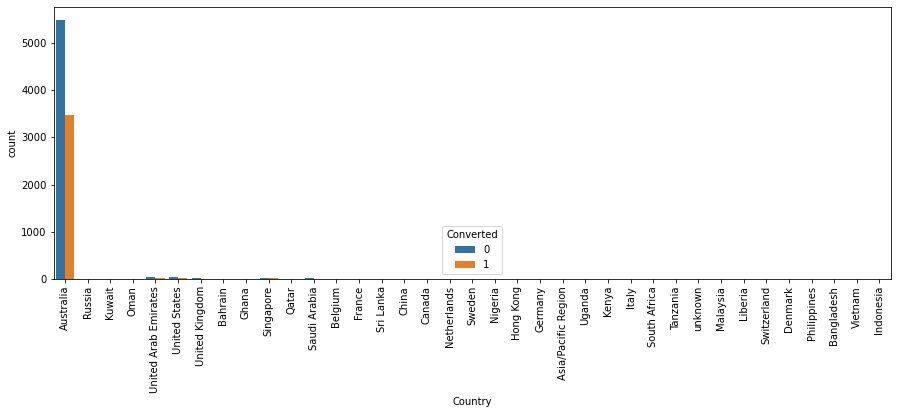

In [338]:
#plotting spread of Country columnn after replacing NaN values

plt.figure(figsize=(15,5))
s1=sns.countplot(data.Country, hue=data.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

As we can see the Number of Values for Australia are quite high (nearly 97% of the Data), this column can be dropped

In [339]:
data.drop(['Country'], 1, inplace = True)

In [340]:
#checking value counts of "City" column

data['City'].value_counts(dropna=False)

NaN                    3669
Melbourne              3222
Sydney & Outskirts      752
Other Cities            686
Other Cities of NSW     457
Other Metro Cities      380
Tier II Cities           74
Name: City, dtype: int64

In [341]:
data['City'] = data['City'].replace(np.nan,'Melbourne')

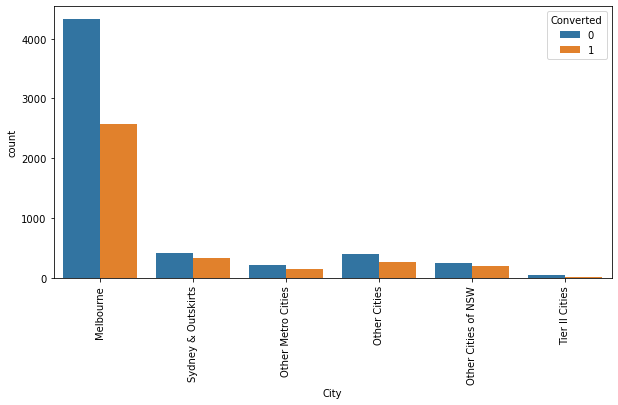

In [342]:
#plotting spread of City columnn after replacing NaN values

plt.figure(figsize=(10,5))
s1=sns.countplot(data.City, hue=data.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

'Tags' feature is a bit different to the two previous. It has many unique values and counting by each value, the majority is NaN.

In [343]:
#checking value counts of Tag variable
data['Tags'].value_counts(dropna=False)

NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with 

Therefore, we will handle this feature a little bit differently, and introduce new value 'Not Specified' for all NaN values.

In [344]:
#replacing Nan values with "Not Specified"
data['Tags'] = data['Tags'].replace(np.nan,'Not Specified')

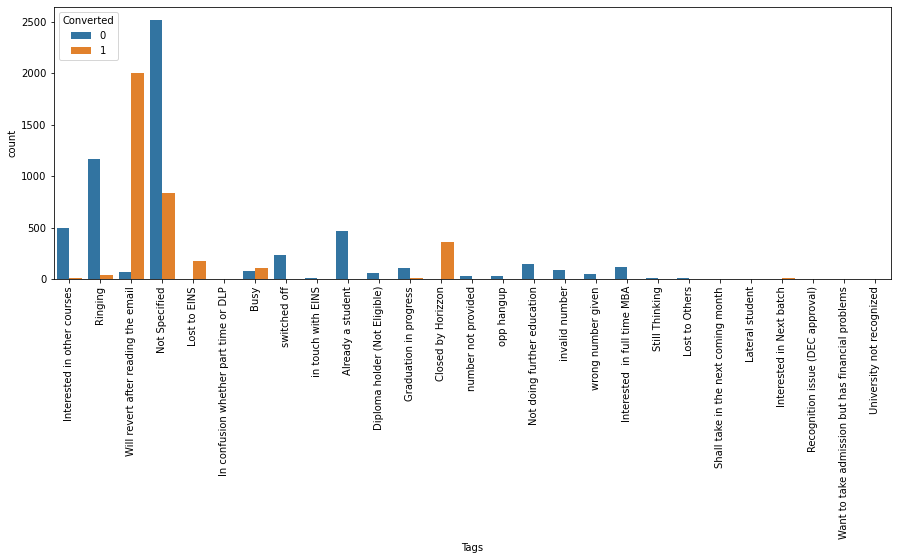

In [345]:
#visualizing count of Variable based on Converted value

plt.figure(figsize=(15,5))
s1=sns.countplot(data['Tags'], hue=data.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

Another thing is that there are many values with little counts of them. To make it more balanced, we will combine such values into one value.

In [346]:
#replacing tags with low frequency with "Other Tags"
data['Tags'] = data['Tags'].replace(['In confusion whether part time or DLP', 'in touch with EINS','Diploma holder (Not Eligible)',
                                     'Approached upfront','Graduation in progress','number not provided', 'opp hangup','Still Thinking',
                                    'Lost to Others','Shall take in the next coming month','Lateral student','Interested in Next batch',
                                    'Recognition issue (DEC approval)','Want to take admission but has financial problems',
                                    'University not recognized'], 'Other_Tags')

data['Tags'] = data['Tags'].replace(['switched off',
                                      'Already a student',
                                       'Not doing further education',
                                       'invalid number',
                                       'wrong number given',
                                       'Interested  in full time MBA'] , 'Other_Tags')

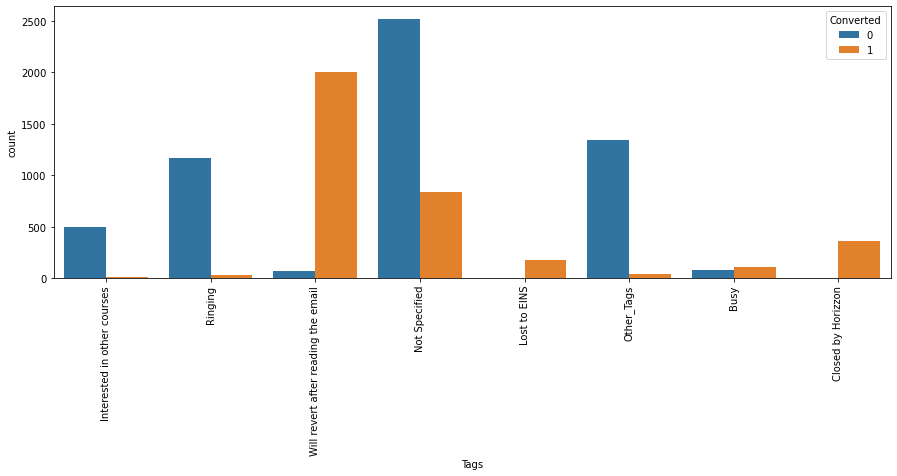

In [347]:
#visualizing count of Variable based on Converted value

plt.figure(figsize=(15,5))
s1=sns.countplot(data['Tags'], hue=data.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [348]:
#checking value counts of Lead Source column

data['Lead Source'].value_counts(dropna=False)

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
Pay per Click Ads       1
NC_EDM                  1
blog                    1
WeLearn                 1
testone                 1
youtubechannel          1
welearnblog_Home        1
Name: Lead Source, dtype: int64

We can replace NaN values and group some of the lower frequency occuring labels under a common label 'Others'.

In [349]:
data['Lead Source'] = data['Lead Source'].replace(np.nan,'Others')
data['Lead Source'] = data['Lead Source'].replace('google','Google')
data['Lead Source'] = data['Lead Source'].replace('Facebook','Social Media')
data['Lead Source'] = data['Lead Source'].replace(['bing','Click2call','Press_Release',
                                                     'youtubechannel','welearnblog_Home',
                                                     'WeLearn','blog','Pay per Click Ads',
                                                    'testone','NC_EDM', 'Live Chat'] ,'Others')                                                   

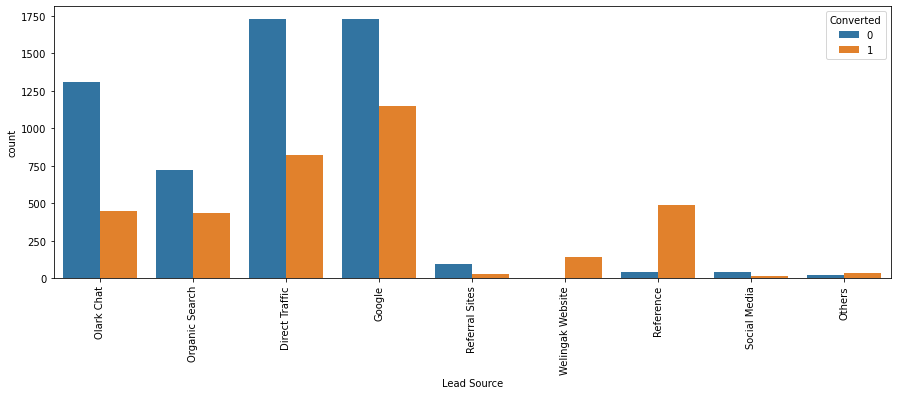

In [350]:
#visualizing count of Variable based on Converted value
plt.figure(figsize=(15,5))
s1=sns.countplot(data['Lead Source'], hue=data.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [351]:
# Last Activity:

data['Last Activity'].value_counts(dropna=False)

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

In [352]:
#replacing Nan Values and combining low frequency values

data['Last Activity'] = data['Last Activity'].replace(np.nan,'Others')
data['Last Activity'] = data['Last Activity'].replace(['Unreachable','Unsubscribed',
                                                        'Had a Phone Conversation', 
                                                        'Approached upfront',
                                                        'View in browser link Clicked',       
                                                        'Email Marked Spam',                  
                                                        'Email Received','Resubscribed to emails',
                                                         'Visited Booth in Tradeshow'],'Others')

In [353]:
# Last Activity:

data['Last Activity'].value_counts(dropna=False)

Email Opened                 3437
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Others                        308
Email Link Clicked            267
Form Submitted on Website     116
Name: Last Activity, dtype: int64

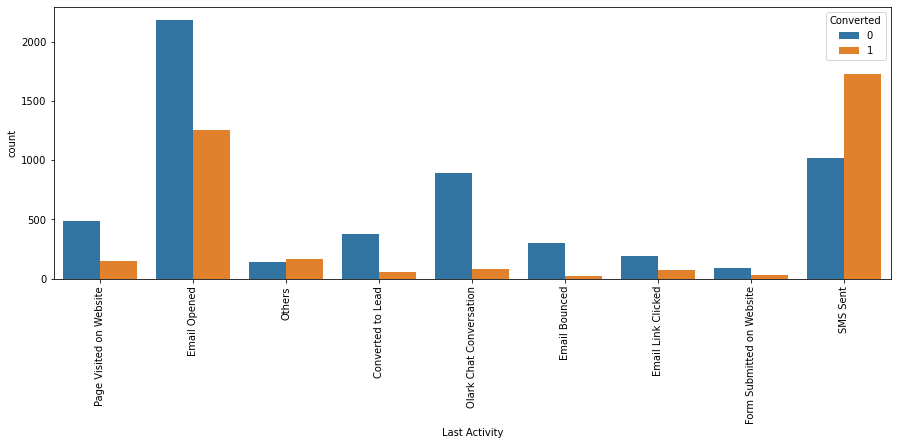

In [354]:
#visualizing count of Variable based on Converted value
plt.figure(figsize=(15,5))
s1=sns.countplot(data['Last Activity'], hue=data.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [355]:
#Check the Null Values in All Columns:
round(100*(data.isnull().sum()/len(data.index)), 2)

Lead Origin                    0.00
Lead Source                    0.00
TotalVisits                    1.48
Total Time Spent on Website    0.00
Page Views Per Visit           1.48
Last Activity                  0.00
City                           0.00
Tags                           0.00
Converted                      0.00
dtype: float64

In [356]:
#Lead Origin
data['Lead Origin'].value_counts(dropna=False)

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

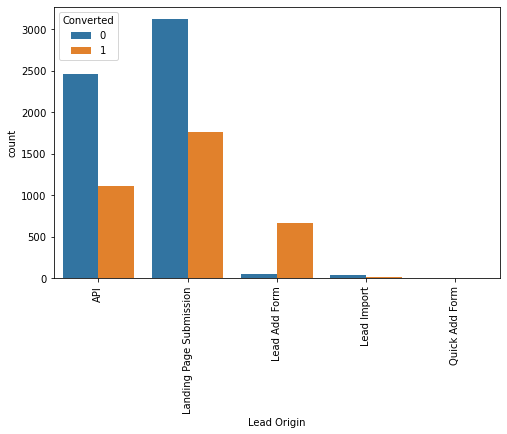

In [357]:
#visualizing count of Variable based on Converted value

plt.figure(figsize=(8,5))
s1=sns.countplot(data['Lead Origin'], hue=data.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [358]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Lead Origin                  9240 non-null   object 
 1   Lead Source                  9240 non-null   object 
 2   TotalVisits                  9103 non-null   float64
 3   Total Time Spent on Website  9240 non-null   int64  
 4   Page Views Per Visit         9103 non-null   float64
 5   Last Activity                9240 non-null   object 
 6   City                         9240 non-null   object 
 7   Tags                         9240 non-null   object 
 8   Converted                    9240 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 649.8+ KB


In [359]:
data.describe()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Converted
count,9103.000000,9240.000000,9103.000000,9240.000000
mean,3.445238,487.698268,2.362820,0.385390
std,4.854853,548.021466,2.161418,0.486714
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,12.000000,1.000000,0.000000
50%,3.000000,248.000000,2.000000,0.000000
75%,5.000000,936.000000,3.000000,1.000000
max,251.000000,2272.000000,55.000000,1.000000


## Missing Values in Numerical Features:

In [360]:
#Check the Null Values in All Columns:
round(100*(data.isnull().sum()/len(data.index)), 2)

Lead Origin                    0.00
Lead Source                    0.00
TotalVisits                    1.48
Total Time Spent on Website    0.00
Page Views Per Visit           1.48
Last Activity                  0.00
City                           0.00
Tags                           0.00
Converted                      0.00
dtype: float64

Here, 'TotalVisits' and 'Page Views Per Visit' are numeric features with the amount of missing values under 2%. As this amount is small, we can simply discard all rows with missing values.

In [361]:
data = data.dropna()

In [362]:
data.shape

(9103, 9)

## Handling Outliers

Let's check the correlation of the numeric values with the target varaible

In [365]:
#Check the % of Data that has Converted Values = 1:

Converted = (sum(data['Converted'])/len(data['Converted'].index))*100
Converted

38.02043282434362

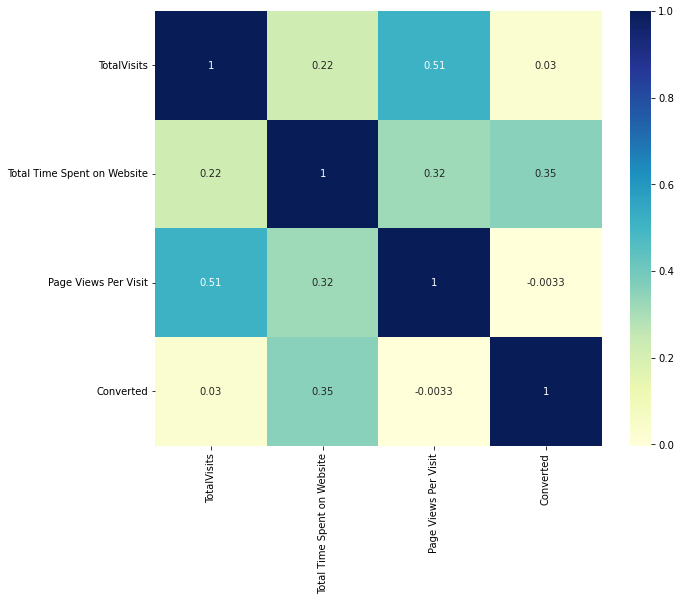

In [366]:
#Checking correlations of numeric values
# figure size
plt.figure(figsize=(10,8))

# heatmap
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

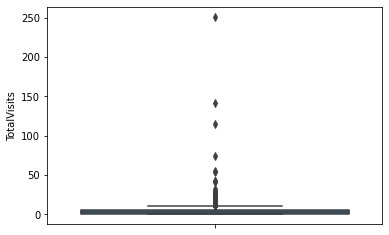

In [367]:
#Total Visits
#visualizing spread of variable

plt.figure(figsize=(6,4))
sns.boxplot(y=data['TotalVisits'])
plt.show()

We can see presence of outliers here

In [368]:
#checking percentile values for "Total Visits"

data['TotalVisits'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
5%          0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

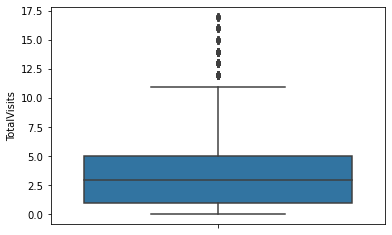

In [369]:
#Outlier Treatment: Remove top & bottom 1% of the Column Outlier values

Q3 = data.TotalVisits.quantile(0.99)
data = data[(data.TotalVisits <= Q3)]
Q1 = data.TotalVisits.quantile(0.01)
data = data[(data.TotalVisits >= Q1)]
sns.boxplot(y=data['TotalVisits'])
plt.show()

In [370]:
data.shape

(9020, 9)

Check for the Next Numerical Column:

In [371]:
#checking percentiles for "Total Time Spent on Website"

data['Total Time Spent on Website'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    9020.000000
mean      479.759534
std       544.688157
min         0.000000
5%          0.000000
25%         7.000000
50%       243.000000
75%       915.250000
90%      1371.000000
95%      1554.050000
99%      1836.620000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

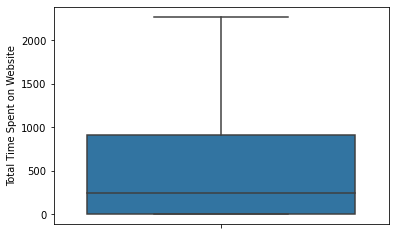

In [372]:
#visualizing spread of numeric variable

plt.figure(figsize=(6,4))
sns.boxplot(y=data['Total Time Spent on Website'])
plt.show()

Since there are no major Outliers for the above variable we don't do any Outlier Treatment for this above Column

Check for Page Views Per Visit:

In [373]:
#checking spread of "Page Views Per Visit"

data['Page Views Per Visit'].describe()

count    9020.000000
mean        2.337271
std         2.062363
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64

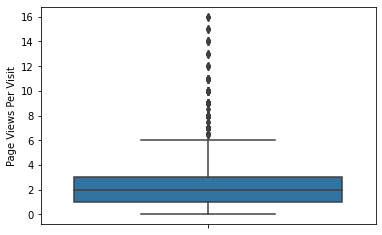

In [374]:
#visualizing spread of numeric variable

plt.figure(figsize=(6,4))
sns.boxplot(y=data['Page Views Per Visit'])
plt.show()

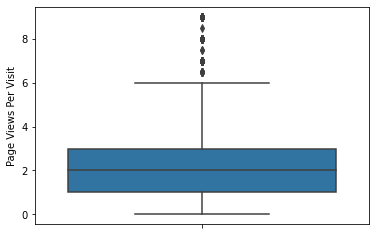

In [375]:
#Outlier Treatment: Remove top & bottom 1% 

Q3 = data['Page Views Per Visit'].quantile(0.99)
data = data[data['Page Views Per Visit'] <= Q3]
Q1 = data['Page Views Per Visit'].quantile(0.01)
data = data[data['Page Views Per Visit'] >= Q1]
sns.boxplot(y=data['Page Views Per Visit'])
plt.show()

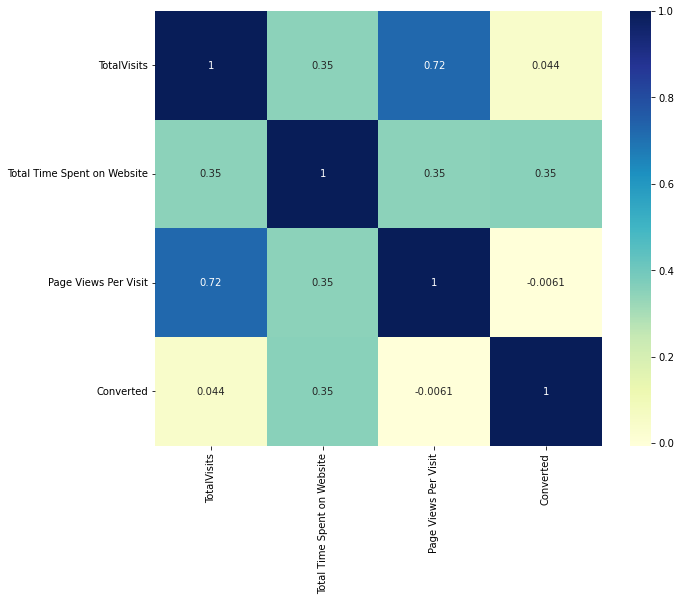

In [376]:
#Checking correlations of numeric values
# figure size
plt.figure(figsize=(10,8))

# heatmap
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

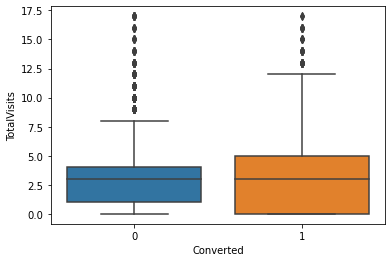

In [185]:
#checking Spread of "Total Visits" vs Converted variable
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = data)
plt.show()

Inference
- Median for converted and not converted leads are the close.
- Nothng conclusive can be said on the basis of Total Visits

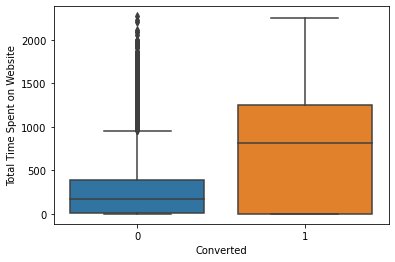

In [186]:
#checking Spread of "Total Time Spent on Website" vs Converted variable

sns.boxplot(x=data.Converted, y=data['Total Time Spent on Website'])
plt.show()

Another way to see that users spending more time on the website are more likely to be converted.

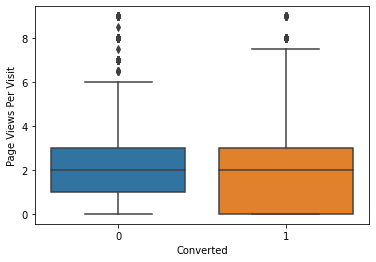

In [187]:
#checking Spread of "Page Views Per Visit" vs Converted variable

sns.boxplot(x=data.Converted,y=data['Page Views Per Visit'])
plt.show()

Nothing can be said specifically for lead conversion from Page Views Per Visit

In [377]:
data.shape

(8953, 9)

### Converting Categorical Features to Numeric:

In [378]:
#getting a list of categorical columns

cat_cols= data.select_dtypes(include=['object']).columns
cat_cols

Index(['Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Tags'], dtype='object')

In [379]:
#getting dummies and dropping the first column and adding the results to the master dataframe
dummy = pd.get_dummies(data[['Lead Origin',
                             'City']], drop_first=True)

data = pd.concat([data,dummy],1)

In [380]:
dummy = pd.get_dummies(data['Lead Source'], prefix  = 'Lead Source')
dummy = dummy.drop(['Lead Source_Others'], 1)
data = pd.concat([data, dummy], axis = 1)

In [381]:
dummy = pd.get_dummies(data['Last Activity'], prefix  = 'Last Activity')
dummy = dummy.drop(['Last Activity_Others'], 1)
data = pd.concat([data, dummy], axis = 1)

In [382]:
dummy = pd.get_dummies(data['Tags'], prefix  = 'Tags')
dummy = dummy.drop(['Tags_Not Specified'], 1)
data = pd.concat([data, dummy], axis = 1)

In [383]:
#dropping the original columns after dummy variable creation

data.drop(cat_cols,1,inplace = True)

In [384]:
data.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Converted,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,City_Other Cities,City_Other Cities of NSW,City_Other Metro Cities,...,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email
0,0.0,0,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,5.0,674,2.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,1532,2.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,305,1.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2.0,1428,1.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [385]:
data.shape

(8953, 35)

## Train-Test Split & Model Building:

In [386]:
from sklearn.model_selection import train_test_split

# Putting response variable to y
y = data['Converted']

X=data.drop('Converted', axis=1)

In [452]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [453]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6267 entries, 9196 to 5825
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   TotalVisits                               6267 non-null   float64
 1   Total Time Spent on Website               6267 non-null   int64  
 2   Page Views Per Visit                      6267 non-null   float64
 3   Lead Origin_Landing Page Submission       6267 non-null   uint8  
 4   Lead Origin_Lead Add Form                 6267 non-null   uint8  
 5   Lead Origin_Lead Import                   6267 non-null   uint8  
 6   City_Other Cities                         6267 non-null   uint8  
 7   City_Other Cities of NSW                  6267 non-null   uint8  
 8   City_Other Metro Cities                   6267 non-null   uint8  
 9   City_Sydney & Outskirts                   6267 non-null   uint8  
 10  City_Tier II Cities              

### Scaling of Data:

In [455]:
#scaling numeric columns

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols=X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

X_train.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,City_Other Cities,City_Other Cities of NSW,City_Other Metro Cities,City_Sydney & Outskirts,...,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email
9196,0.668862,1.848117,1.455819,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4696,-0.030697,-0.037832,0.399961,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3274,0.319082,-0.642138,-0.127967,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2164,-0.380477,-0.154676,-0.127967,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1667,0.319082,1.258415,-0.481679,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [456]:
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test.head()

### Model Building using Stats Model & RFE:

In [457]:
import statsmodels.api as sm

In [458]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE
rfe = RFE(logreg)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [459]:
rfe.support_

array([False,  True, False, False,  True, False, False, False, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True, False, False, False,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True])

In [460]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 11),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 10),
 ('Lead Origin_Landing Page Submission', False, 2),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 14),
 ('City_Other Cities', False, 12),
 ('City_Other Cities of NSW', False, 16),
 ('City_Other Metro Cities', False, 15),
 ('City_Sydney & Outskirts', False, 17),
 ('City_Tier II Cities', False, 9),
 ('Lead Source_Direct Traffic', True, 1),
 ('Lead Source_Google', True, 1),
 ('Lead Source_Olark Chat', False, 13),
 ('Lead Source_Organic Search', True, 1),
 ('Lead Source_Reference', False, 5),
 ('Lead Source_Referral Sites', True, 1),
 ('Lead Source_Social Media', False, 6),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Converted to Lead', False, 4),
 ('Last Activity_Email Bounced', False, 3),
 ('Last Activity_Email Link Clicked', False, 8),
 ('Last Activity_Email Opened', True, 1),
 ('Last Activity_Form Submitted on Website', False, 18)

In [461]:
#list of RFE supported columns
col = X_train.columns[rfe.support_]
col

Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Direct Traffic', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Referral Sites',
       'Lead Source_Welingak Website', 'Last Activity_Email Opened',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'Tags_Busy', 'Tags_Closed by Horizzon',
       'Tags_Interested in other courses', 'Tags_Lost to EINS',
       'Tags_Other_Tags', 'Tags_Ringing',
       'Tags_Will revert after reading the email'],
      dtype='object')

In [462]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'City_Other Cities', 'City_Other Cities of NSW',
       'City_Other Metro Cities', 'City_Sydney & Outskirts',
       'City_Tier II Cities', 'Lead Source_Olark Chat',
       'Lead Source_Reference', 'Lead Source_Social Media',
       'Last Activity_Converted to Lead', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Page Visited on Website'],
      dtype='object')

We can check the Variance Inflation Factor to see if there is any correlation between the variables

In [463]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [464]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Lead Source_Google,2.10
9,Last Activity_SMS Sent,2.07
2,Lead Source_Direct Traffic,2.00
7,Last Activity_Email Opened,2.00
1,Lead Origin_Lead Add Form,1.96
16,Tags_Will revert after reading the email,1.93
14,Tags_Other_Tags,1.42
4,Lead Source_Organic Search,1.41
15,Tags_Ringing,1.41
6,Lead Source_Welingak Website,1.35


If we saw the values of 5-10, that would mean that some features are highly correlated between each other and this may deteriorate the model quality. However, here we see all values are relativelly low, so we can move on now to building a model.

We can now try on the prepared model a few different models and see how they perform.

In [401]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

classifiers = {
    "LogisticRegression":   LogisticRegression(),
    "StochasticGradient":   SGDClassifier(),
    "KNeighbors":           KNeighborsClassifier(),
    "DecisionTree":         DecisionTreeClassifier(),
    "DecisionTreeBalanced": DecisionTreeClassifier(class_weight="balanced"),
    "RandomForest":         RandomForestClassifier(n_jobs=-1, n_estimators=10),
    "RandomForestBalanced": RandomForestClassifier(class_weight="balanced", n_jobs=-1, n_estimators=2),
    "Ridge":                RidgeClassifier(),
    "LinearSupportVector":  SVC(kernel='linear')
}
X_train_sm = sm.add_constant(X_train[col])
for base_clf in classifiers.keys():   
    calibrated_clf = CalibratedClassifierCV(base_estimator=classifiers[base_clf], cv=3)
    cvs = cross_val_score(calibrated_clf, X_train_sm, y_train, cv=5)
    print(base_clf, cvs, sum(cvs)/len(cvs))


LogisticRegression [0.92025518 0.92902711 0.92338388 0.92338388 0.91779729] 0.9227694681090741
StochasticGradient [0.91786284 0.92503987 0.92577813 0.92418196 0.9169992 ] 0.9219724018018638
KNeighbors [0.9122807  0.9138756  0.91460495 0.92258579 0.91061453] 0.9147923134397701
DecisionTree [0.8907496  0.90191388 0.91620112 0.90343176 0.90023943] 0.9025071566676978
DecisionTreeBalanced [0.89473684 0.90271132 0.91540303 0.896249   0.896249  ] 0.9010698406758391
RandomForest [0.90829346 0.91068581 0.91939346 0.91221069 0.90582602] 0.9112818867890905
RandomForestBalanced [0.90909091 0.89952153 0.91300878 0.9066241  0.90742219] 0.9071335016057157
Ridge [0.9138756  0.91626794 0.91779729 0.90901836 0.91221069] 0.9138339754923113
LinearSupportVector [0.91068581 0.91068581 0.92338388 0.9169992  0.91540303] 0.9154315448346615


We can see that the Logistic Regression model delievered the best accuracy with StochasticGradient beeing very close to it. This demonstrates that the data have strong linear dependencies that were well picked up by Logistic Regression.

Let's single out Logistic Regression

In [449]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

X_train_sm = sm.add_constant(X_train[col])

base_clf = LogisticRegression()
calibrated_clf = CalibratedClassifierCV(base_estimator=base_clf, cv=5)
cvs = cross_val_score(calibrated_clf, X_train, y_train, cv=5)
print(cvs, sum(cvs)/len(cvs))

[0.92424242 0.92663477 0.92418196 0.92338388 0.9169992 ] 0.9230884473754217


Now we check the model on the test set

In [471]:
calibrated_clf.fit(X_train_sm, y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(), cv=5)

In [472]:
y_train_p = calibrated_clf.predict(X_train_sm)
report = classification_report(y_train, y_train_p)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3882
           1       0.92      0.88      0.90      2385

    accuracy                           0.92      6267
   macro avg       0.92      0.92      0.92      6267
weighted avg       0.92      0.92      0.92      6267



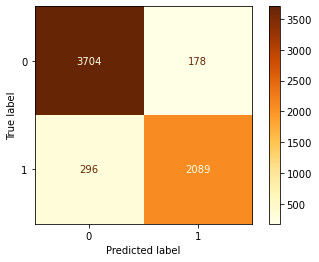

In [473]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix 
#matrix = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_p, cmap='YlOrBr')
plt.show()

In [480]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train, y_train_p )

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('TP',TP)
print('TN',TN)
print('FP',FP)
print('FN',FN)

TP 2089
TN 3704
FP 178
FN 296


In [481]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8758909853249476

In [482]:
# Let us calculate specificity
TN / float(TN+FP)

0.9541473467284904

In [483]:
# plotting ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

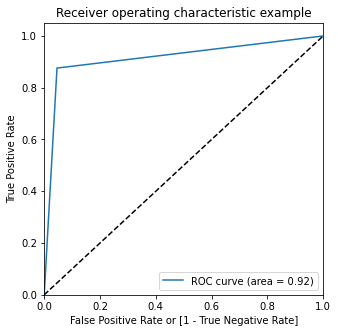

In [484]:
draw_roc(y_train, y_train_p)

### Observation:
So as we can see above the model seems to be performing well. The ROC curve has a value of 0.97, which is very good. We have the following values for the Train Data:
- Accuracy : 92.29%
- Sensitivity : 91.70%
- Specificity : 92.66%

In [485]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_p)

0.92148213498015

In [486]:
recall_score(y_train, y_train_p)

0.8758909853249476

In [487]:
from sklearn.metrics import precision_recall_curve

In [488]:

p, r, thresholds = precision_recall_curve(y_train, y_train_p)

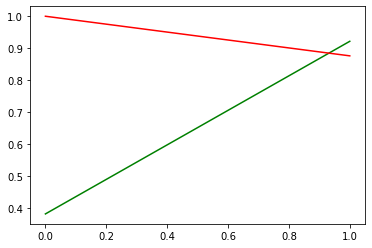

In [489]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### PREDICTIONS ON TEST SET

In [490]:
X_test.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,City_Other Cities,City_Other Cities of NSW,City_Other Metro Cities,City_Sydney & Outskirts,...,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email
7681,0.668862,-0.304384,0.135997,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
984,-0.030697,-0.538073,0.399961,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
8135,-0.380477,0.794688,-0.127967,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6915,0.319082,-0.614753,-0.127967,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2712,-0.030697,-0.412100,0.399961,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [493]:
X_test_sm = sm.add_constant(X_test[col])
X_test_sm.head()

,const,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Organic Search,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_SMS Sent,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email
7681,1.0,-0.304384,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
984,1.0,-0.538073,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
8135,1.0,0.794688,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6915,1.0,-0.614753,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2712,1.0,-0.412100,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [495]:
y_test_p = calibrated_clf.predict(X_test_sm)
    
report = classification_report(y_test, y_test_p)
print(report)


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1676
           1       0.92      0.88      0.90      1010

    accuracy                           0.93      2686
   macro avg       0.93      0.92      0.92      2686
weighted avg       0.93      0.93      0.93      2686



In [496]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test, y_test_p)

0.9274013402829486

In [497]:
confusion2 = metrics.confusion_matrix(y_test, y_test_p )
confusion2

array([[1600,   76],
       [ 119,  891]])

In [498]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [499]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8821782178217822

In [500]:
# Let us calculate specificity
TN / float(TN+FP)

0.954653937947494

In [503]:
precision_score(y_test, y_test_p)

0.921406411582213

In [502]:
recall_score(y_test, y_test_p)

0.8821782178217822

## Summary of the values obtained for Train & Test:

### <u> Train Data: </u>
- Accuracy : 92.29%
- Precision : 92.14%
- Recall : 87.58%

### <u> Test Data: </u>
- Accuracy : 92.74%
- Precision : 92.14%
- Recall : 88.21%

The Model seems to predict the Conversion Rate very well and we should be able to give the CEO confidence in making good calls based on this model